<a href="https://colab.research.google.com/github/AlexeyBoroda/-arsharing/blob/main/Borodulin_telecom_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Прогноз оттока клиентов" для ТелеДом

**Цель**: Разработать модель бинарной классификации для выявления клиентов с риском расторжения договора (ROC-AUC ≥ 0.85, доп. метрика Accuracy) с целью предложения специальных условий.

**Ключевые данные (SQLite, актуальны на 01.02.2020):**
1. `contract` - ID, даты договора, оплата, платежи, расходы
2. `personal` - ID, демография (пол, возраст, семейное положение)
3. `internet` - ID, тип подключения (DSL/оптоволокно), доп. услуги
4. `phone` - ID, многоканальность

**Основные услуги**:
- Интернет (DSL/оптоволокно) + телефон
- Дополнительно: безопасность (антивирус), ТВ/фильмы, техподдержка, облако

**Технические требования:**
1. **Модели**:
   - Деревья: Random Forest / Decision Tree
   - Бустинги: XGBoost/LightGBM/CatBoost
   - Нейросети: DNN

# Подготовка среды

## Импорты

In [ ]:
!pip install ydata-profiling
!pip install -q scikeras

In [61]:
# Основные библиотеки
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
from tabulate import tabulate

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Профилирование данных
import ydata_profiling
from ydata_profiling import ProfileReport

# Предобработка данных
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Моделирование и оценка
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    KFold
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score
)

# Модели ML
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Нейронные сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Input,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

## Константы

In [2]:
random_state = 300625
test_size = 0.25

## Функции

### Анализ таблиц и предобработка

In [56]:
def analyze_and_normalize(df, table_name):
    """
    Анализирует таблицу и приводит названия столбцов к нижнему регистру.
    Возвращает DataFrame с измененными названиями столбцов для дальнейшего использования.
    """
    # Запоминаем исходные названия
    original_columns = df.columns

    # Приводим к нижнему регистру (изменяем исходный DataFrame)
    df.columns = [col.lower() for col in df.columns]

    print(f"\nАнализ таблицы {table_name}:")
    print(f"Измененные названия столбцов: {original_columns} -> {df.columns.tolist()}")

    print("\n1. Первые 5 строк:")
    print(df.head())

    print("\n2. Основная информация:")
    print(df.info())

    print("\n3. Описательная статистика:")
    print(df.describe(include='all'))

    print("\n4. Количество пропущенных значений:")
    print(df.isna().sum())

    print("\n5. Количество дубликатов:", df.duplicated().sum())

    # Возвращаем DataFrame с измененными названиями
    return df

In [58]:
def normalize_columns(dataset, columns):
    """
    Преобразует текст в указанных столбцах:
    - в нижний регистр
    - пробелы и тире заменяет на подчёркивания
    Возвращает новый DataFrame с изменениями.
    """
    df = dataset.copy()
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower().str.replace(' ', '_').str.replace('-', '_')
        else:
            print(f"Предупреждение: столбец '{col}' не найден в DataFrame.")
    return df

###  Визуализация признаков

In [60]:
def plot_full_churn_analysis(df, target_col='churn_enddate'):
    """
    Полная визуализация всех признаков с разделением по статусу клиента.
    Обрабатывает пропущенные значения и автоматически подбирает типы графиков.
    """
    # Создаем временный столбец с категориальными значениями
    df = df.copy()
    df['status'] = df[target_col].map({1: 'Активен', 0: 'Ушёл'})

    # Разделяем признаки по типам
    categorical = ['type', 'gender', 'seniorcitizen', 'partner', 'dependents',
                  'internetservice', 'paymentmethod', 'duration_group', 'payment_stability']
    boolean = ['paperlessbilling', 'onlinesecurity', 'onlinebackup',
               'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
               'multiplelines']
    numerical = ['monthlycharges', 'totalcharges', 'tenure_months']

    # Настройка стиля и размера
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(24, 36))
    gs = GridSpec(6, 4, figure=plt.gcf())

    # --- 1. Категориальные признаки ---
    for i, col in enumerate(categorical[:8]):
        ax = plt.subplot(gs[i//4, i%4])
        sns.countplot(data=df, x=col, hue='status', palette='viridis', ax=ax)
        ax.set_title(f'Соотношение по {col}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.legend(title='Статус')

    # --- 2. Булевы признаки ---
    for i, col in enumerate(boolean[:8]):
        ax = plt.subplot(gs[(i+8)//4, (i+8)%4])
        sns.countplot(data=df, x=col, hue='status', palette='coolwarm', ax=ax)
        ax.set_title(f'Соотношение по {col}')
        ax.legend(title='Статус')

    # --- 3. Числовые признаки ---
    # Распределение monthlycharges
    ax1 = plt.subplot(gs[4, 0])
    sns.boxplot(data=df, x='status', y='monthlycharges', palette='pastel', ax=ax1,
               order=['Ушёл', 'Активен'])
    ax1.set_title('Распределение ежемесячных платежей')

    # Распределение totalcharges
    ax2 = plt.subplot(gs[4, 1])
    sns.boxplot(data=df, x='status', y='totalcharges', palette='pastel', ax=ax2,
               order=['Ушёл', 'Активен'])
    ax2.set_title('Распределение общих платежей')

    # Распределение tenure_months
    ax3 = plt.subplot(gs[4, 2])
    sns.histplot(data=df, x='tenure_months', hue='status', bins=30, kde=True,
                palette='ocean', element='step', ax=ax3,
                hue_order=['Ушёл', 'Активен'])
    ax3.set_title('Распределение срока обслуживания')

    # Scatter plot tenure vs charges
    ax4 = plt.subplot(gs[4, 3])
    sns.scatterplot(data=df, x='tenure_months', y='monthlycharges',
                   hue='status', palette='magma', ax=ax4)
    ax4.set_title('Срок обслуживания vs Ежемесячные платежи')

    # --- 4. Дополнительные графики ---
    # Пропущенные значения
    ax5 = plt.subplot(gs[5, :2])
    missing = df.isnull().mean().sort_values(ascending=False)
    missing = missing[missing > 0]
    sns.barplot(x=missing.values, y=missing.index, palette='rocket', ax=ax5)
    ax5.set_title('Доля пропущенных значений')
    ax5.set_xlabel('Процент пропусков')

    # Корреляция числовых признаков
    ax6 = plt.subplot(gs[5, 2:])
    numeric_df = df[numerical + [target_col]].corr()
    sns.heatmap(numeric_df, annot=True, cmap='coolwarm', center=0, ax=ax6)
    ax6.set_title('Корреляция числовых признаков')

    plt.tight_layout()
    plt.show()


# Шаг 1. Подготовка данных

## Загрузка данных из SQLite

In [55]:
# Путь к файлу базы данных
db_path = '/content/drive/MyDrive/Colab Notebooks/Telecom/dataset/ds-plus-final.db'

# Соединение с базой данных
conn = sqlite3.connect(db_path)

In [5]:
# Проверим список таблиц в базе данных
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, conn)
print("Доступные таблицы в базе данных:")
print(tables)

Доступные таблицы в базе данных:
              name
0         data_arc
1        data_bulk
2   data_bulk_time
3   data_wire_time
4         contract
5         personal
6            phone
7         internet
8         data_gas
9        data_temp
10       data_wire


In [6]:
# Загрузим данные из всех таблиц
contract = pd.read_sql("SELECT * FROM contract", conn)
personal = pd.read_sql("SELECT * FROM personal", conn)
internet = pd.read_sql("SELECT * FROM internet", conn)
phone = pd.read_sql("SELECT * FROM phone", conn)

In [57]:
# Анализируем каждую таблицу
analyze_and_normalize(contract, "contract (информация о договорах)")
analyze_and_normalize(personal, "personal (персональные данные клиентов)")
analyze_and_normalize(internet, "internet (информация об интернет-услугах)")
analyze_and_normalize(phone, "phone (информация об услугах телефонии)")


Анализ таблицы contract (информация о договорах):
Измененные названия столбцов: Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object') -> ['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges']

1. Первые 5 строк:
   customerid  begindate enddate            type paperlessbilling  \
0  7590-VHVEG 2020-01-01     NaT  month_to_month              yes   
1  5575-GNVDE 2017-04-01     NaT        one_year               no   
2  3668-QPYBK 2019-10-01     NaT  month_to_month              yes   
3  7795-CFOCW 2016-05-01     NaT        one_year               no   
4  9237-HQITU 2019-09-01     NaT  month_to_month              yes   

               paymentmethod  monthlycharges  totalcharges  
0           electronic_check           29.85         31.04  
1               mailed_check           56.95       2071.84  
2               mailed_che

,customerid,multiplelines
0,5575-GNVDE,no
1,3668-QPYBK,no
2,9237-HQITU,no
3,9305-CDSKC,yes
4,1452-KIOVK,yes
...,...,...
6356,2569-WGERO,no
6357,6840-RESVB,yes
6358,2234-XADUH,yes
6359,8361-LTMKD,yes


### Выводы предварительного анализа данных
**1. Проверка таблиц**
- **Все таблицы содержат данные**:
  - `contract` (7043 строк) — информация о договорах
  - `personal` (7043 строк) — персональные данные
  - `internet` (5517 строк) — интернет-услуги (не все клиенты подключены)
  - `phone` (6361 строк) — телефонные услуги (не все клиенты подключены)
- **Количество таблиц соответствует условию задачи** (4 таблицы).
---
**2. Анализ каждой таблицы**

**Таблица `contract`**:
- **Пропуски/дубликаты**: Нет.
- **Аномалии**:
  - `EndDate="No"` для активных клиентов
  - `MonthlyCharges` и `TotalCharges` хранятся как текст (нужно преобразовать в числа).

**Таблица `personal`**:
- **Пропуски/дубликаты**: Нет.
- **Аномалии**: `SeniorCitizen` хранится как текст (хотя значения 0/1).

**Таблица `internet`**:
- **Пропуски/дубликаты**: Нет.
- **Аномалии**:
  - Только 5517 клиентов из 7043 используют интернет.
  - Услуги `OnlineSecurity`, `TechSupport` чаще отключены

**Таблица `phone`**:
- **Пропуски/дубликаты**: Нет.
- **Аномалии**:
  - Только 6361 клиентов из 7043 используют телефон.

---
**Рекомендации по предобработке**
1. **Преобразование данных**: все текстовые данные привести к нижнему регистру, пробелы и дефисы заменить на нижнее подчеркивание.
   

2. **Обработка аномалий**:
   - Для `contract`:
     - Преобразовать `MonthlyCharges` и `TotalCharges` в числа.
     - Заменить `"No"` в `EndDate` на `pd.NaT` (для активных клиентов).
   - Для `personal`:
     - Преобразовать `SeniorCitizen` в `int` (0/1).
   - Для `internet`/`phone`:
     - Добавить флаги `HasInternet`/`HasPhone` (так как не все клиенты подключены).

3. **Кодирование категорий**:
   - Бинарные признаки (`Yes/No` → `1/0`).
   - One-Hot для `PaymentMethod`, `InternetService`.

4. **Новые признаки**:
   - `Tenure` (длительность контракта в днях).
   - `TotalSpent` = `MonthlyCharges` * `Tenure` (опционально).
---

**Итог**
Данные чистые, но требуют:
1. Преобразования типов.
2. Аккуратного объединения таблиц.
3. Создания целевой переменной `Churn` на основе `EndDate`.  
**Следующий шаг**: объединение таблиц и Feature Engineering.

## Обработка данных

### 1. Обработка аномалий в таблицах


#### 1.1. Таблица `contract`

In [10]:
#1 Преобразование типа даных
contract['monthlycharges'] = pd.to_numeric(contract['monthlycharges'], errors='coerce')
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'], errors='coerce')

# Проверка результатов
print(contract[['monthlycharges', 'totalcharges']].dtypes)

monthlycharges    float64
totalcharges      float64
dtype: object


In [11]:
# 2 Замена "No" на pd.NaT и изменение типа данных на datetime
contract['enddate'] = contract['enddate'].replace('No', pd.NaT)
contract['enddate'] = pd.to_datetime(contract['enddate'])
contract['begindate'] = pd.to_datetime(contract['begindate'])

# Проверка
print("Количество активных клиентов (enddate=NaT):", contract['enddate'].isna().sum())
contract.info()

Количество активных клиентов (enddate=NaT): 5942
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1101 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [13]:
#3 Преобразование данных к нижнему регистру
contract = normalize_columns(contract, ['type', 'paperlessbilling', 'paymentmethod'])
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,NaT,month_to_month,yes,electronic_check,29.85,31.04
1,5575-GNVDE,2017-04-01,NaT,one_year,no,mailed_check,56.95,2071.84
2,3668-QPYBK,2019-10-01,NaT,month_to_month,yes,mailed_check,53.85,226.17
3,7795-CFOCW,2016-05-01,NaT,one_year,no,bank_transfer_(automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,NaT,month_to_month,yes,electronic_check,70.70,353.50


In [59]:
#4 Проверка на пропуски
print("Пропуски по столбцам:\n", contract.isnull().sum())

# Проверка на дубликаты
print("\nКоличество дубликатов:", contract.duplicated().sum())


Пропуски по столбцам:
 customerid             0
begindate              0
enddate             5942
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges          11
dtype: int64

Количество дубликатов: 0


#### **Выводы по таблице `contract` для пайпа**


1. Обработка пропусков для `TotalCharges` - заполнить средним (SimpleImputer).
2. Числовые: `MonthlyCharges`, `TotalCharges` - масштабировать (StandardScaler)
3. Категориальные:
    - `PaymentMethod`- One-Hot Encoding (drop='first')
    - `PaperlessBilling` - перевести в бинарный признак (0/1)

#### 1.2. Таблица `personal`

In [15]:
#1. Приведем seniorcitizen к бинарному признаку
personal['seniorcitizen'] = personal['seniorcitizen'].astype(int)

In [16]:
#2. Приведем данные к нижнему регистру
personal = normalize_columns(personal, ['gender', 'partner', 'dependents'])
print(personal.head())
print(personal.info())

#3 Проверка на пропуски
print("Пропуски по столбцам:\n", personal.isnull().sum())
# Проверка на дубликаты
print("\nКоличество дубликатов:", personal.duplicated().sum())


   customerid  gender  seniorcitizen partner dependents
0  7590-VHVEG  female              0     yes         no
1  5575-GNVDE    male              0      no         no
2  3668-QPYBK    male              0      no         no
3  7795-CFOCW    male              0      no         no
4  9237-HQITU  female              0      no         no
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
Пропуски по столбцам:
 customerid       0
gender           0
seniorcitizen    0
partner          0
dependents       0
dtype: int64

Количество дубликатов: 0


#### **Выводы по таблице `personal` для пайпа**

- Обработать категориальные признаки - перевести в бинарный признак (0/1).

Пример, male/female = 1/0, yes/no - 1/0

#### 1.3. Таблица `internet`

In [17]:
#1. Приведем данные к нижнему регистру
internet = normalize_columns(internet, ['internetservice', 'onlinesecurity', 'onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies'])
print(internet.head())
print(internet.info())

#2 Проверка на пропуски
print("Пропуски по столбцам:\n", internet.isnull().sum())
#3 Проверка на дубликаты
print("\nКоличество дубликатов:", internet.duplicated().sum())

   customerid internetservice onlinesecurity onlinebackup deviceprotection  \
0  7590-VHVEG             dsl             no          yes               no   
1  5575-GNVDE             dsl            yes           no              yes   
2  3668-QPYBK             dsl            yes          yes               no   
3  7795-CFOCW             dsl            yes           no              yes   
4  9237-HQITU     fiber_optic             no           no               no   

  techsupport streamingtv streamingmovies  
0          no          no              no  
1          no          no              no  
2          no          no              no  
3         yes          no              no  
4          no          no              no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   

#### **Выводы по таблице `internet` для пайпа**

- Обработать категориальные признаки - перевести в бинарный признак (0/1).

Пример, yes/no - 1/0, dsl/fiber_optic - 1/0

#### 1.4. Таблица `phone`

In [18]:
#1. Приведем данные к нижнему регистру
phone = normalize_columns(phone, ['multiplelines'])
print(phone.head())
print(phone.info())

#2 Проверка на пропуски
print("Пропуски по столбцам:\n", phone.isnull().sum())
#3 Проверка на дубликаты
print("\nКоличество дубликатов:", phone.duplicated().sum())

   customerid multiplelines
0  5575-GNVDE            no
1  3668-QPYBK            no
2  9237-HQITU            no
3  9305-CDSKC           yes
4  1452-KIOVK           yes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
Пропуски по столбцам:
 customerid       0
multiplelines    0
dtype: int64

Количество дубликатов: 0


#### **Выводы по таблице `phone` для пайпа**

- Обработать категориальные признаки - перевести в бинарный признак (0/1).

Пример, yes/no - 1/0

### 2. Объединение таблиц

**Принцип объединения:**
1. Основной таблицей будет contract (все клиенты)
2. Используем left join
3. Особенности обработки: будут пропуски для интернет-услуг и телефонии

In [19]:
# 1. Объединяем contract с personal
merged_df = pd.merge(contract, personal, on='customerid', how='left')

# 2. Затем добавляем internet
merged_df = pd.merge(merged_df, internet, on='customerid', how='left')

# 3. добавляем phone
merged_df = pd.merge(merged_df, phone, on='customerid', how='left')

In [20]:
# Анализируем
analyze_and_normalize(merged_df, "merged_df (объединенная таблица)")


Анализ таблицы merged_df (объединенная таблица):
Измененные названия столбцов: Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object') -> ['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'gender', 'seniorcitizen', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

1. Первые 5 строк:
   customerid  begindate enddate            type paperlessbilling  \
0  7590-VHVEG 2020-01-01     NaT  month_to_month              yes   
1  5575-GNVDE 2017-04-01     NaT        one_year               no   
2  3668-QPYBK 2

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,NaT,month_to_month,yes,electronic_check,29.85,31.04,female,0,yes,no,dsl,no,yes,no,no,no,no,NaN
1,5575-GNVDE,2017-04-01,NaT,one_year,no,mailed_check,56.95,2071.84,male,0,no,no,dsl,yes,no,yes,no,no,no,no
2,3668-QPYBK,2019-10-01,NaT,month_to_month,yes,mailed_check,53.85,226.17,male,0,no,no,dsl,yes,yes,no,no,no,no,no
3,7795-CFOCW,2016-05-01,NaT,one_year,no,bank_transfer_(automatic),42.30,1960.60,male,0,no,no,dsl,yes,no,yes,yes,no,no,NaN
4,9237-HQITU,2019-09-01,NaT,month_to_month,yes,electronic_check,70.70,353.50,female,0,no,no,fiber_optic,no,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,one_year,yes,mailed_check,84.80,2035.20,male,0,yes,yes,dsl,yes,no,yes,yes,yes,yes,yes
7039,2234-XADUH,2014-02-01,NaT,one_year,yes,credit_card_(automatic),103.20,7430.40,female,0,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,yes
7040,4801-JZAZL,2019-03-01,NaT,month_to_month,yes,electronic_check,29.60,325.60,female,0,yes,yes,dsl,yes,no,no,no,no,no,NaN
7041,8361-LTMKD,2019-07-01,NaT,month_to_month,yes,mailed_check,74.40,520.80,male,1,yes,no,fiber_optic,no,no,no,no,no,no,yes


### Выводы по датасету merged_df

1. **Структура данных**:  
   - 7043 записи, 19 столбцов.  
   - Основные категории: клиентские данные (ID, даты), услуги (тип, оплата), демография (пол, возраст).  

2. **Пропуски**:  
   - `enddate`: 5942 пропуска (активные клиенты).Не обрабатываем, заменим на бинарный признак.  
   - `totalcharges`: 11 пропусков. Не обрабатываем. В папе заполним.  
   - Услуги интернета (`internetservice` и др.): 1526 пропусков. Обработали. Указали, что не пользуюися услугами.  

3. **Особенности**:  
   - Нет дубликатов.  

**Итог**: Датсет требует проработку пропусков, проработки целевого признака и сегментации клиентов.

### 3. Генерация признаков

#### 3.1. Определение целевой переменной `churn_enddate`

In [22]:
#1. Создаем целевую переменную (активный/неактивный)
merged_df['churn_enddate'] = merged_df['enddate'].isna().astype(int) # 1=активен, 0=ушел
display(merged_df['churn_enddate'].value_counts(normalize=True))

,proportion
churn_enddate,
1,0.843675
0,0.156325


#### 3.2. Длительность контракта `tenure_months`

In [23]:
# Фиксированная дата среза
CUTOFF_DATE = pd.to_datetime('2020-02-01')

# Создаём признак длительности в месяцах
merged_df['tenure_months'] = round((
    # Для ушедших клиентов: enddate - begindate
    merged_df['enddate'].where(merged_df['enddate'].notna(),
    # Для активных: дата среза - begindate
    CUTOFF_DATE) - merged_df['begindate']
).dt.days/ 30.44,  # Среднее дней в месяце
    2  # Округление до 2 знаков
)

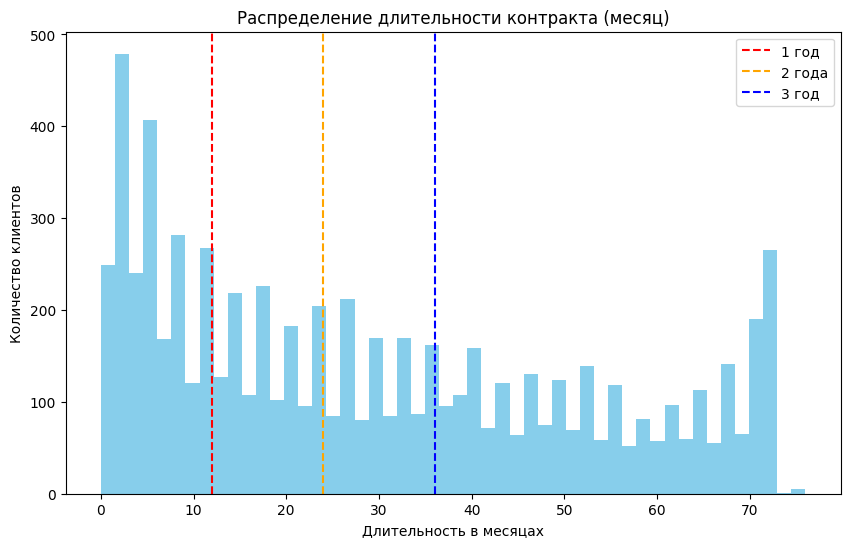

In [24]:
# Визуализация распределения
plt.figure(figsize=(10, 6))
plt.hist(merged_df['tenure_months'], bins=50, color='skyblue')
plt.title('Распределение длительности контракта (месяц)')
plt.xlabel('Длительность в месяцах')
plt.ylabel('Количество клиентов')
plt.axvline(x=12, color='red', linestyle='--', label='1 год')
plt.axvline(x=24, color='orange', linestyle='--', label='2 года')
plt.axvline(x=36, color='blue', linestyle='--', label='3 год')
plt.legend()
plt.show()

In [25]:
# Создаем категории длительности контракта
bins = [0, 1, 12, 24, 1000]  # Границы в месяцах
labels = ['до 1 мес', '1-12 мес', '1-2 года', 'более 2 лет']  # Простые названия

# Создаем и сразу преобразуем в категориальный тип
merged_df['duration_group'] = pd.cut(
    merged_df['tenure_months'],
    bins=bins,
    labels=labels,
    right=False  # Включаем левую границу (0 <= x < 1)
).astype('category')

# Проверяем результат
merged_df['duration_group'].value_counts()

,count
duration_group,
более 2 лет,3572
1-12 мес,2197
1-2 года,1261
до 1 мес,13


#### 3.2. Введем признак "Стабильность платежей" для анализ поведения клиента

In [26]:
# Расчет среднего исторического платежа
merged_df['avg_historical_spent'] = merged_df['totalcharges'] / merged_df['tenure_months']


In [27]:
# Отклонение текущего платежа от среднего (%)
merged_df['deviation_pct'] = (
    (merged_df['monthlycharges'] - merged_df['avg_historical_spent'])
    / merged_df['avg_historical_spent'] * 100
).round(2)


In [28]:
# Границы интервалов (5 точек = 4 интервала)
bins = [-np.inf, -10, 0, 10, np.inf]

# Метки для 4 интервалов (на 1 меньше, чем границ!)
labels = [
    'significant_decrease',  # (-inf, -10)
    'minor_decrease',        # [-10, 0)
    'stable',                # [0, 10)
    'significant_increase'   # [10, inf)
]

# Создаем категориальный признак
merged_df['payment_stability'] = pd.cut(
    merged_df['deviation_pct'],
    bins=bins,
    labels=labels,
    ordered=True  # Важно для порядковых категорий
)

# Проверка результата
print(merged_df['payment_stability'].value_counts())

payment_stability
minor_decrease          4312
stable                  2720
significant_decrease       0
significant_increase       0
Name: count, dtype: int64


#### Вывод стабильности платежей клиентов

Распределение клиентов по категориям стабильности платежей:

| Категория              | Количество клиентов | Доля от общего числа |
|------------------------|---------------------|----------------------|
| `minor_decrease`       | 4,312               | 61.2%                |
| `stable`               | 2,720               | 38.8%                |
| `significant_decrease` | 0                   | 0.0%                 |

**Ключевые наблюдения**

1. **Отсутствие резких снижений**:
   - Нет клиентов с категорией `significant_decrease` (< -10%)
   - Все изменения платежей находятся в диапазоне от -10% до 0%

2. **Преобладание незначительных снижений**:
   - 61.2% клиентов имеют небольшое снижение платежей (-10% до 0%)
   - 38.8% клиентов сохраняют стабильные платежи (±0%)

In [30]:
# Удаление избыточных признаков
to_drop = [
    'customerid', 'begindate','enddate',
    'avg_historical_spent', 'deviation_pct'
]
final_df = merged_df.drop(columns=to_drop)

# Проверка
print(final_df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   object  
 1   paperlessbilling   7043 non-null   object  
 2   paymentmethod      7043 non-null   object  
 3   monthlycharges     7043 non-null   float64 
 4   totalcharges       7032 non-null   float64 
 5   gender             7043 non-null   object  
 6   seniorcitizen      7043 non-null   int64   
 7   partner            7043 non-null   object  
 8   dependents         7043 non-null   object  
 9   internetservice    7043 non-null   object  
 10  onlinesecurity     7043 non-null   object  
 11  onlinebackup       7043 non-null   object  
 12  deviceprotection   7043 non-null   object  
 13  techsupport        7043 non-null   object  
 14  streamingtv        7043 non-null   object  
 15  streamingmovies    7043 non-null   object  
 16  multip

 #### Вывод:
 1. Целепую переменую `enddate`преобразовали в бинарное значение `churn_enddate`
 2. Добавили признаки производные из даты заключения контракта `begindate`
 3. Длительность контракта абонента не используем чтобы избежать утечки данных.

# Шаг 2. EDA

## 1. Отчет ProfileReport

Файл отчета представлен в отдельном файле (report.html)

In [34]:
# Для исследовательского анализа данных используем библиотеку ydata_profiling
profile = ProfileReport(final_df, title="Data Report")
profile.to_notebook_iframe()
profile.to_file("report.html")  # Для сохранения в HTML


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 23.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Отчет по исследовательскому анализу данных (EDA)

**1. Анализ ключевых переменных**

**Категориальные переменные:**
 - Пол: Сбалансирован (мужчины: 3555, женщины: 3488).
 - Метод оплаты: 4 уникальных значения, чаще всего встречается "electronic_check" (2365).
 - Отток (churn_enddate): Дисбаланс классов (1: 5942, 0: 1101).

**Булевы переменные:**
 - Безбумажный биллинг: 59.2% True, 40.8% False.
 - Партнер: Почти сбалансировано (False: 51.7%, True: 48.3%).
 - Иждивенцы: Сильный дисбаланс (False: 70%, True: 30%).

**Числовые переменные:**
 - Ежемесячные платежи:

            Среднее: 64.76, диапазон: 18.25–118.75.
            Скошено вправо (скошенность: -0.22).

 - Общие платежи:

            Среднее: 2118.62, диапазон: 19.05–9221.38.
            Скошено вправо (скошенность: 1.18).

 - Срок обслуживания (месяцы):

            Среднее: 29.52, диапазон: 0–76.02.
            11 нулевых значений (0.2%), возможно, новые клиенты.

**2. Пропущенные значения**
 - Высокий уровень пропусков (21.7%): onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies. Рассмотреть вопрос создания отдельного признака "Прочие интернет услуги"

 - Умеренный уровень пропусков (9.7%): multiplelines.

- Низкий уровень пропусков (0.2%): totalcharges, payment_stability.

**3. Корреляции и влияние на целевую переменную `churn_enddate`**

3.1. **Наиболее значимые признаки для `churn_enddate`**:  
   - `tenure_months` (**0.287**) – сильнее всего влияет на отток
   - `totalcharges` (**0.233**) – высокая корреляция  
   - `monthlycharges` (**0.173**) – умеренное влияние  
   - `duration_group` (**0.168**) – умеренное влияние  

3.2. **Признаки с умеренным влиянием** (корр. **0.1–0.16**):  
   - `payment_stability`, `partner`, `multiplelines`, `onlinesecurity`, `onlinebackup`, `deviceprotection`, `streamingmovies`, `streamingtv`.  

3.3. **Слабые или незначимые признаки** (корр. < **0.1**):  
   - `gender` (**0.005**), `dependents` (**0.03**), `paperlessbilling` (**0.053**), `seniorcitizen` (**0.055**), `techsupport` (**0.047**) – можно рассмотреть для исключения.  

3.4. **Потенциальные кандидаты на исключение** из-за мультиколлинеарности или дублирования:  
   - `totalcharges` (корр. с `tenure_months` – **0.877**, с `monthlycharges` – **0.646**).  
   - `duration_group` (корр. с `tenure_months` – **0.72**).  
   - `internetservice` (корр. с `monthlycharges` – **0.807**).  

## 2. Визуализация
Визуализируйте соотношение ушедших и оставшихся клиентов для каждого признака.

/tmp/ipython-input-36-904863832.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-36-904863832.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-36-904863832.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-36-904863832.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-36-904863832.py:28: UserWarning: set_ticklabels() should only be used with a fixed number

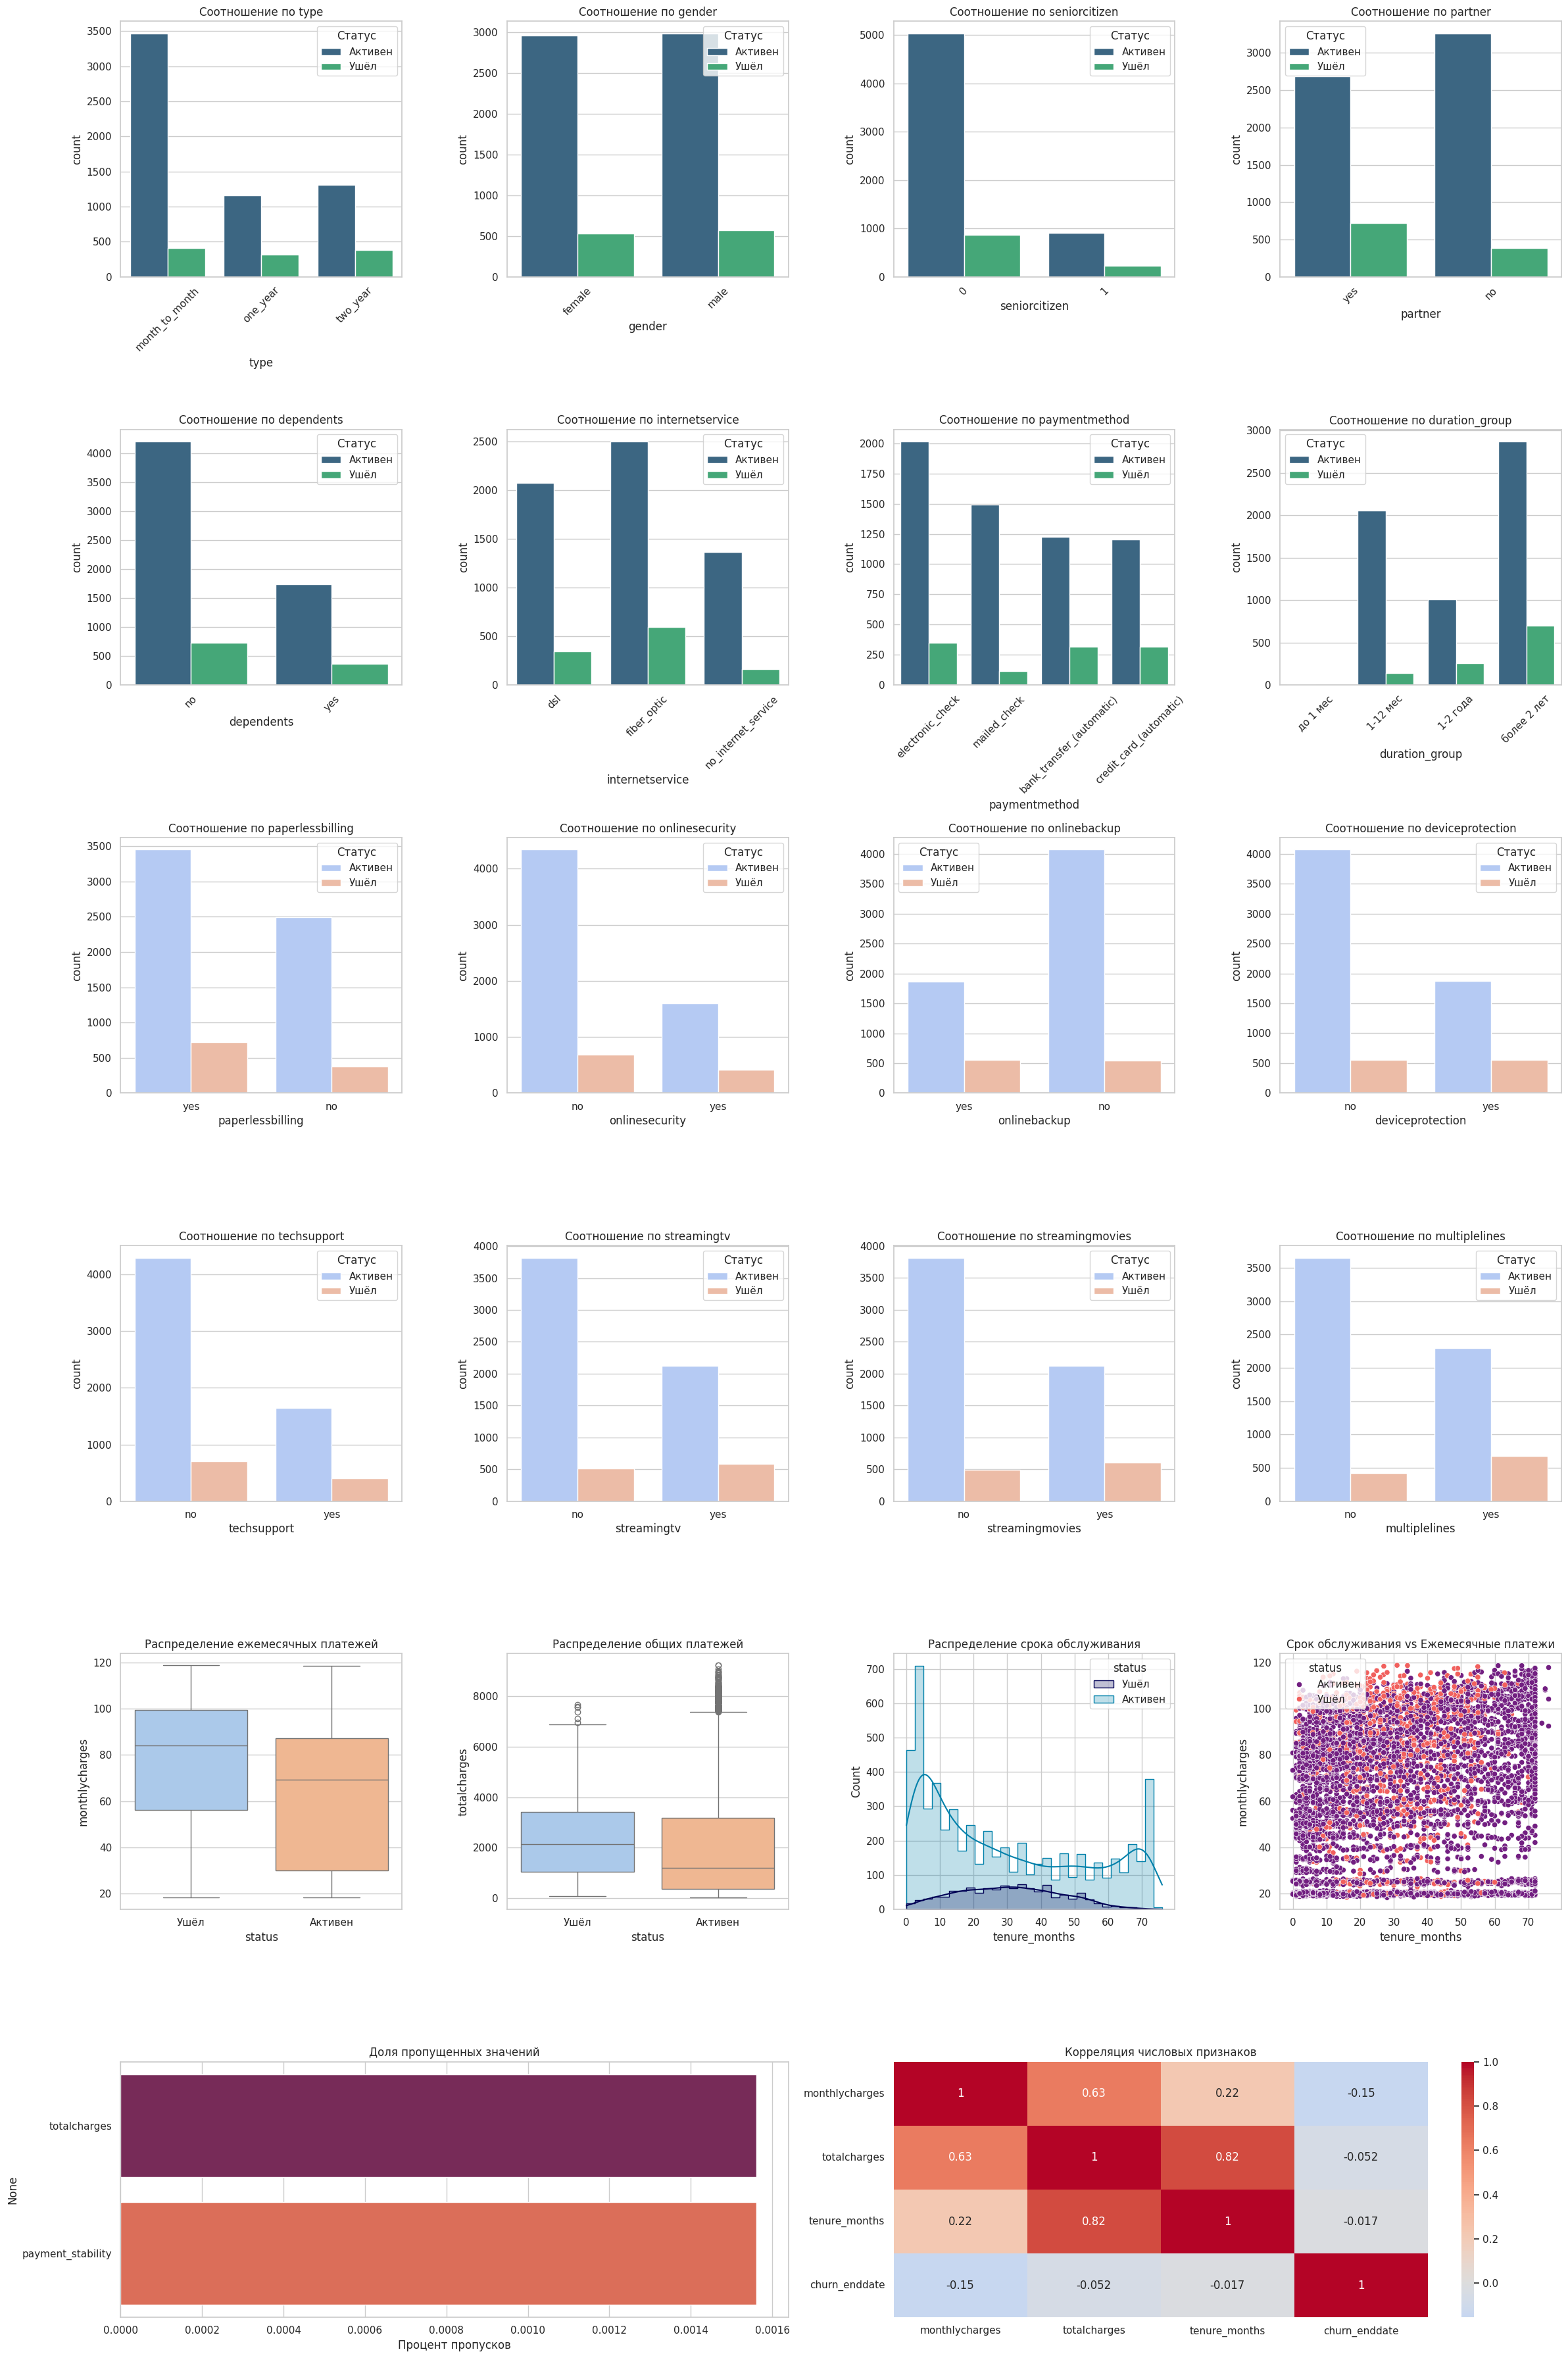

In [37]:
# Построим визуализацию
plot_full_churn_analysis(final_df)

## **Краткий анализ влияния каждого из признаков**
---

### **Категориальные признаки**

| Признак             | Вывод о влиянии на отток                                                                   |
| ------------------- | ------------------------------------------------------------------------------------------ |
| `type`              | Клиенты с контрактом на **год или два** уходят значительно **реже**, чем на **месяц**.     |
| `gender`            | Разницы **практически нет**. Пол **не влияет** на отток.                                   |
| `seniorcitizen`     | **Пенсионеры** чаще уходят                                             |
| `partner`           | Наличие партнёра снижает вероятность ухода.                                                |
| `dependents`        | Наличие иждивенцев — фактор **удержания**  |
| `internetservice`   | Самый высокий отток у пользователей **Fiber optic** |
| `paymentmethod`     | У клиентов с **electronic check** — **наивысший отток**  |
| `duration_group`    | Наибольший отток в группе **до 1 года**,                                  |
| `payment_stability` | Клиенты с **нестабильными платежами** чаще уходят.                                         |

---

### **Булевы признаки (услуги)**

| Признак            | Вывод о влиянии на отток                                          |
| ------------------ | ----------------------------------------------------------------- |
| `paperlessbilling` | Клиенты без бумажного биллинга (онлайн счета) **чаще уходят**.    |
| `onlinesecurity`   | Наличие онлайн-защиты **значительно снижает** отток.              |
| `onlinebackup`     | Пользователи резервного копирования — **менее склонны** к оттоку. |
| `deviceprotection` | Услуга защиты устройства **уменьшает** вероятность ухода.         |
| `techsupport`      | Техподдержка — **сильный фактор удержания**.                      |
| `streamingtv`      | Наличие стриминга ТВ **незначительно повышает** отток.            |
| `streamingmovies`  | Схожая ситуация — **умеренный рост** оттока.                      |
| `multiplelines`    | Практически **не влияет** на отток, слабая корреляция.            |

---

### **Числовые признаки**

| Признак          | Вывод о влиянии на отток                                                                |
| ---------------- | --------------------------------------------------------------------------------------- |
| `monthlycharges` | Ушедшие клиенты имели **высокие ежемесячные платежи**.                                  |
| `totalcharges`   | Ушедшие имели **меньшие суммарные платежи** — то есть **новые клиенты**.                |
| `tenure_months`  | Чем дольше клиент обслуживается, тем **меньше шанс**, что он уйдёт. Сильная корреляция. |

---

### Основные выводы:

* Наиболее значимые признаки, **увеличивающие вероятность оттока**:
  `type = Month-to-month`,
  `internetservice = Fiber optic`,
  `paymentmethod = Electronic check`,
  `monthlycharges`,
  `tenure_months`.
* Наиболее значимые признаки, **снижающие отток**:
`onlinesecurity`,
 `techsupport`,
 `deviceprotection`


# Шаг 3. Обучите модель

In [40]:
# Скопируем данные
data = final_df.copy()

# Целевая переменная и признаки
y = data['churn_enddate']
X = data.drop(columns=['churn_enddate'])

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=random_state
)


In [41]:
#Уберем из анализа следующие признаки:
#- gender, dependents, seniorcitizen, paperlessbilling, techsupport (из-за слабой связи с целевой переменной).
#- totalcharges (из-за мультиколлинеарности с tenure_months).
#- duration_group (дублирует tenure_months).
#- internetservice (дублирует monthlycharges).
#- streamingtv (можно оставить streamingmovies).


# Определение типов признаков
feature_types = {
    'numeric': [
        'monthlycharges',
        'totalcharges',
        'tenure_months'],
    'binary': [
        #'gender',
        #'seniorcitizen',
        'partner',
        #'dependents',
        #'paperlessbilling',
        'onlinesecurity',
        'onlinebackup',
        'deviceprotection',
        #'techsupport',
        #'streamingtv',
        'streamingmovies',
        'multiplelines'
    ],
    'categorical': [
        'type',
        #'internetservice',
        'paymentmethod',
        #'duration_group',
        'payment_stability'
    ]
}

numeric_features = feature_types['numeric']
binary_features = feature_types['binary']
categorical_features = feature_types['categorical']


In [42]:
# Создание словарей отображения для бинарных признаков на обучающей выборке
binary_mappings = {}
for col in binary_features:
    # factorize возвращает codes и uniques
    codes, uniques = pd.factorize(X_train[col].fillna(X_train[col].mode()[0]))
    # mapping: код -> оригинальное значение
    binary_mappings[col] = dict(enumerate(uniques))


# Вывод словарей кодирования бинарных признаков
print("Словари кодирования бинарных признаков:")
for col, mapping in binary_mappings.items():
    print(f"{col}: {mapping}")


Словари кодирования бинарных признаков:
partner: {0: 'yes', 1: 'no'}
onlinesecurity: {0: 'yes', 1: 'no'}
onlinebackup: {0: 'yes', 1: 'no'}
deviceprotection: {0: 'no', 1: 'yes'}
streamingmovies: {0: 'no', 1: 'yes'}
multiplelines: {0: 'yes', 1: 'no'}


In [44]:
# 1. Трансформер для бинарных признаков
def binary_encoder(df):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    result = df.copy()
    for col in result.columns:
        result[col] = pd.factorize(result[col].fillna(result[col].mode()[0]))[0]
    return result.astype(int)

binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', FunctionTransformer(binary_encoder, feature_names_out='one-to-one', validate=False))
])

# 2. Трансформер для числовых признаков
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

# 3. Трансформер для категориальных признаков
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Общий препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [45]:
# 1. RF с GridSearchCV (с учетом дисбаланса)
rf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(
        random_state=random_state,
        class_weight='balanced'))
])
rf_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_leaf': [1, 3]
}
rf_search = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    refit=True
)

# Обучение
rf_search.fit(X_train, y_train)

# Вывод результатов
print("\nЛучшие параметры RF:", rf_search.best_params_)
print("Средний ROC-AUC на кросс-валидации:", rf_search.best_score_)

y_train_pred = rf_search.predict(X_train)
print("Accuracy на обучающем наборе:", accuracy_score(y_train, y_train_pred))


Лучшие параметры RF: {'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 200}
Средний ROC-AUC на кросс-валидации: 0.8179169782891915
Accuracy на обучающем наборе: 0.8754259750094661


In [46]:
# 2. XGBoost с RandomizedSearchCV (с учетом дисбаланса классов)
xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state,
        scale_pos_weight=len(y_train[y_train==1]) / len(y_train[y_train==0])  # активные/ушедшие
    ))
])

xgb_param_dist = {
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7],
    'clf__n_estimators': [100, 200, 300],
    'clf__min_child_weight': [1, 3, 5]
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=random_state,
    n_jobs=-1,
    refit=True
)

xgb_search.fit(X_train, y_train)

# Предсказание на обучающих данных
y_train_pred_xgb = xgb_search.predict(X_train)

# Вывод результатов
print("\nЛучшие параметры XGB:", xgb_search.best_params_)
print("XGB CV ROC-AUC:", xgb_search.best_score_)
print("XGB Accuracy на обучающем наборе:", accuracy_score(y_train, y_train_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Лучшие параметры XGB: {'clf__n_estimators': 300, 'clf__min_child_weight': 1, 'clf__max_depth': 7, 'clf__learning_rate': 0.1}
XGB CV ROC-AUC: 0.884781331433558
XGB Accuracy на обучающем наборе: 0.9611889435819765


In [47]:
#Нейросеть
#1. Оптимизированные гиперпараметры
#HP = {
#    'layers': [64, 32, 16],
#    'dropouts': [0.6, 0.5, 0.4],
#    'l2_reg': [0.01, 0.005, 0.001],
#    'lr': 0.01,
#    'batch_size': 64,
#    'epochs': 200,
#    'patience': 10,
#    'class_weight': {0: len(y_train[y_train==1])/len(y_train[y_train==0]), 1: 1.0}
#}
#HP = {
#    'layers': [64],              # Всего 1 слой (вместо 2)
#    'dropouts': [0.3],           # Меньше dropout
#    'l2_reg': [0.001,0.001],             # Общая регуляризация для всех слоёв
#    'lr': 0.001,                 # Learning rate без изменений
#    'batch_size': 32,            # Batch size без изменений
#    'epochs': 50,                # Ещё меньше эпох (было 100)
#    'patience': 3,               # Ранняя остановка срабатывает быстрее
#    'class_weight': {0: len(y_train[y_train==1])/len(y_train[y_train==0]), 1: 1.0}
#}

HP = {
    'layers': [16],             # 1 слой с 32 нейронами (можно даже 16)
    'dropouts': [0.2],             # Лёгкий dropout (или вообще убрать)
    'l2_reg': [0.0,0.0],              # Без L2-регуляризации
    'lr': 0.001,                # Стандартный learning rate
    'batch_size': 32,           # Типичный batch size
    'epochs': 30,               # Очень мало эпох
    'patience': 2,              # Ранняя остановка почти сразу
    'class_weight': {0: len(y_train[y_train==1])/len(y_train[y_train==0]), 1: 1.0}
}


# 2. Оптимизированная функция создания модели
def build_model(input_dim):
    model = Sequential([Input(shape=(input_dim,))])

    for units, drop, reg in zip(HP['layers'], HP['dropouts'], HP['l2_reg']):
        model.add(Dense(units, activation='relu', kernel_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(Dropout(drop))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=HP['lr'])
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['AUC', 'accuracy'])
    return model

# 3. Кросс-валидация с улучшенным мониторингом (добавлен accuracy)
def evaluate_model(X, y, preprocessor, n_splits=5):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    X_processed = preprocessor.transform(X)
    input_dim = X_processed.shape[1]

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores_auc = []
    scores_acc = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_processed), 1):
        X_tr, X_v = X_processed[train_idx], X_processed[val_idx]
        y_tr, y_v = y.iloc[train_idx], y.iloc[val_idx]

        model = build_model(input_dim)
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_v, y_v),
            epochs=HP['epochs'],
            batch_size=HP['batch_size'],
            callbacks=[EarlyStopping(
                patience=HP['patience'],
                monitor='val_AUC',
                mode='max',
                restore_best_weights=True,
                verbose=1
            )],
            class_weight=HP['class_weight'],
            verbose=0
        )

        val_pred = model.predict(X_v).flatten()
        auc = roc_auc_score(y_v, val_pred)
        acc = accuracy_score(y_v, (val_pred > 0.5).astype(int))
        scores_auc.append(auc)
        scores_acc.append(acc)
        print(f"Fold {fold} | Val AUC: {auc:.4f} | Val Accuracy: {acc:.4f} | Epochs: {len(history.history['loss'])}")

    return np.mean(scores_auc), np.std(scores_auc), np.mean(scores_acc), np.std(scores_acc)

# 4. Финальное обучение
def train_final_model(X, y, preprocessor):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    X_processed = preprocessor.transform(X)
    input_dim = X_processed.shape[1]

    model = build_model(input_dim)
    history = model.fit(
        X_processed, y,
        epochs=HP['epochs'],
        batch_size=HP['batch_size'],
        class_weight=HP['class_weight'],
        callbacks=[EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=HP['patience'],
            restore_best_weights=True
        )],
        validation_split=0.2,
        verbose=1
    )
    return model

# 5. Основной процесс
print("Обучение препроцессора...")
preprocessor.fit(X_train)

print("\nЗапуск кросс-валидации...")
mean_auc, std_auc, mean_acc, std_acc = evaluate_model(X_train, y_train, preprocessor)
print(f"\nРезультаты кросс-валидации:")
print(f"Средний AUC: {mean_auc:.4f} (±{std_auc:.4f})")
print(f"Средняя Accuracy: {mean_acc:.4f} (±{std_acc:.4f})")

print("\nОбучение финальной модели на всех данных...")
final_model_nn = train_final_model(X_train, y_train, preprocessor)

Обучение препроцессора...

Запуск кросс-валидации...
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 20.
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 1 | Val AUC: 0.8373 | Val Accuracy: 0.7417 | Epochs: 22
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 22.
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 2 | Val AUC: 0.8188 | Val Accuracy: 0.7521 | Epochs: 24
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 22.
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3 | Val AUC: 0.8322 | Val Accuracy: 0.7386 | Epochs: 24
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 15.
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4 | Val AUC: 0.8225 | Val Accuracy: 0.7424 | Epochs: 17
Restoring model weights from the end of the best epoch: 29.
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 5 | Val AUC: 0.8396 | Val Accuracy: 0.7519 | Epochs: 30

Результаты кросс-валидации:
Средний AUC: 0.8

# Шаг 4. Протестируем модель и продемонстрируйте её работу

In [48]:
# Функция для оценки моделей на тестовых данных
def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Для нейронной сети нужен особый подход
        if name == 'Neural Network':
            X_test_processed = preprocessor.transform(X_test)
            y_pred = model.predict(X_test_processed).flatten()
        else:
            y_pred = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_pred)
        results[name] = auc
        print(f"{name} Test AUC: {auc:.4f}")

    return results

# Создаем словарь с лучшими версиями моделей
best_models = {
    'Random Forest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_,
    'Neural Network': final_model_nn
}

# Оцениваем модели на тестовых данных
test_results = evaluate_models(best_models, X_test, y_test)

# Выводим результаты
print("\nИтоговые результаты на тестовых данных:")
for model_name, auc_score in test_results.items():
    print(f"{model_name}: AUC = {auc_score:.4f}")

Random Forest Test AUC: 0.8250
XGBoost Test AUC: 0.8994
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Test AUC: 0.7392

Итоговые результаты на тестовых данных:
Random Forest: AUC = 0.8250
XGBoost: AUC = 0.8994
Neural Network: AUC = 0.7392


In [49]:
# Собираем все рассчитанные метрики из памяти
final_results = [
    {
        'Модель': 'Random Forest',
        'Accuracy (train)': accuracy_score(y_train, y_train_pred),
        'Accuracy (test)': accuracy_score(y_test, rf_search.predict(X_test)),
        'ROC-AUC (train)': rf_search.best_score_,
        'ROC-AUC (test)': test_results['Random Forest'],
        'Параметры': str(rf_search.best_params_)[:50] + '...'
    },
    {
        'Модель': 'XGBoost',
        'Accuracy (train)': accuracy_score(y_train, y_train_pred_xgb),
        'Accuracy (test)': accuracy_score(y_test, xgb_search.predict(X_test)),
        'ROC-AUC (train)': xgb_search.best_score_,
        'ROC-AUC (test)': test_results['XGBoost'],
        'Параметры': str(xgb_search.best_params_)[:50] + '...'
    },
    {

         'Модель': 'Neural Network',
        'Accuracy (train)': accuracy_score(y_train, (final_model_nn.predict(preprocessor.transform(X_train)) > 0.5).astype(int)),
        'Accuracy (test)': accuracy_score(y_test, (final_model_nn.predict(preprocessor.transform(X_test)) > 0.5).astype(int)),
        'ROC-AUC (train)': mean_auc,
        'ROC-AUC (test)': test_results['Neural Network'],
        'Параметры': str(HP)[:50] + '...'

    }
]

# Стилизация таблицы
def colorize(val):
    color = 'green' if isinstance(val, float) and val > 0.8 else 'black'
    return f'color: {color}'

# Вывод в трех форматах
print("═"*80)
print("СВОДНАЯ ТАБЛИЦА МЕТРИК".center(80))
print("═"*80)


# DataFrame с подсветкой
df = pd.DataFrame(final_results)
styled_df = df.style.format({
    'Accuracy (train)': '{:.4f}',
    'Accuracy (test)': '{:.4f}',
    'ROC-AUC (train)': '{:.4f}',
    'ROC-AUC (test)': '{:.4f}'
}).applymap(colorize)

print("\nВизуализированный DataFrame:")
display(styled_df)

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
════════════════════════════════════════════════════════════════════════════════
                             СВОДНАЯ ТАБЛИЦА МЕТРИК                             
════════════════════════════════════════════════════════════════════════════════

Визуализированный DataFrame:


/tmp/ipython-input-49-2947048767.py:52: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(colorize)


,Модель,Accuracy (train),Accuracy (test),ROC-AUC (train),ROC-AUC (test),Параметры
0,Random Forest,0.8754,0.8098,0.8179,0.8250,"{'clf__max_depth': 10, 'clf__min_samples_leaf': 3,..."
1,XGBoost,0.9612,0.8932,0.8848,0.8994,"{'clf__n_estimators': 300, 'clf__min_child_weight'..."
2,Neural Network,0.7384,0.6905,0.8301,0.7392,"{'layers': [16], 'dropouts': [0.2], 'l2_reg': [0.0..."


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score,
                             accuracy_score, roc_auc_score, precision_recall_curve)

In [51]:
# Вывод основных метрик
best_model_name = max(test_results, key=test_results.get)
best_model = best_models[best_model_name]
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1-score": f1_score(y_test, y_test_pred),
    "ROC-AUC": roc_auc_score(y_test, y_test_proba)
}

print(f"\nЛучшая модель: {best_model_name}\n")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


Лучшая модель: XGBoost

Accuracy: 0.8932
Precision: 0.8929
Recall: 0.9926
F1-score: 0.9401
ROC-AUC: 0.8994


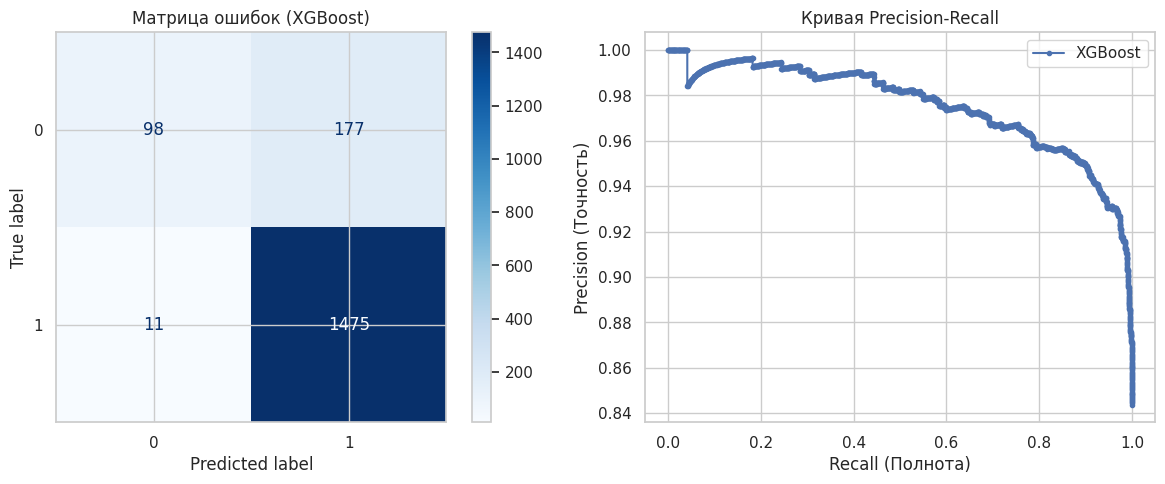

In [52]:
#Визуализация
#Матрица ошибок
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title(f'Матрица ошибок ({best_model_name})')

# 3. Кривая Precision-Recall
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.plot(recall, precision, marker='.', label=best_model_name)
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('Кривая Precision-Recall')
plt.legend()
plt.tight_layout()
plt.show()


Важность признаков для лучшей модели:
                             Feature  Importance
11                     type_two_year    6.958069
9                type_month_to_month    4.711223
2                      tenure_months    4.224663
16  payment_stability_minor_decrease    4.146834
15        paymentmethod_mailed_check    3.906240
8                      multiplelines    3.798793
3                            partner    3.172099
5                       onlinebackup    2.561692
10                     type_one_year    2.136710
14    paymentmethod_electronic_check    2.054334


/tmp/ipython-input-53-772431423.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='plasma')


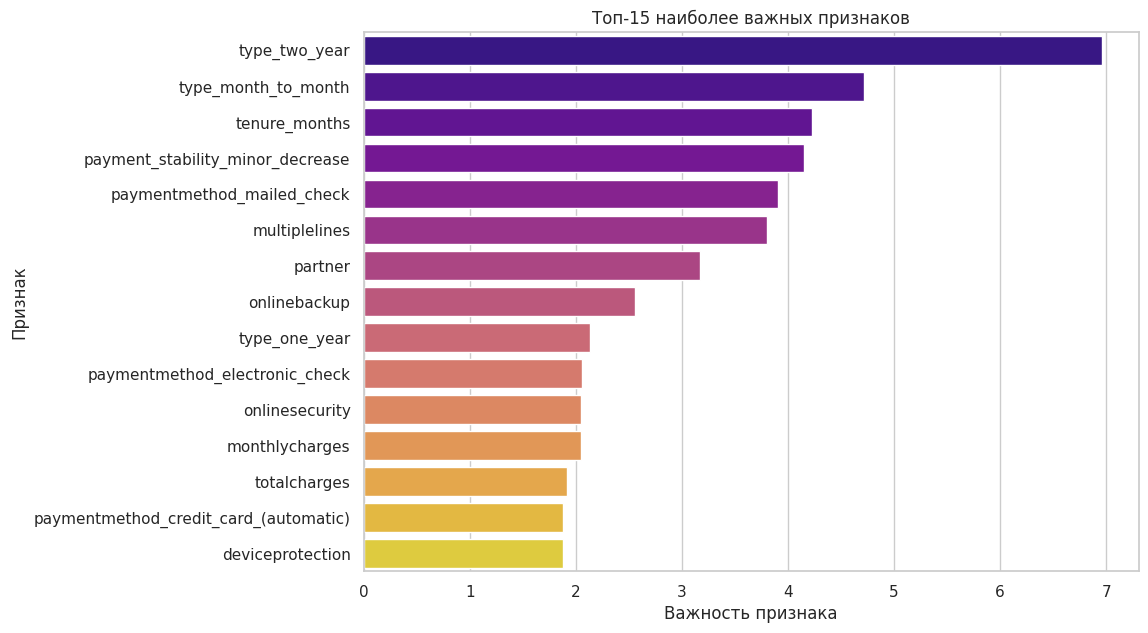

In [53]:
# Анализ важности признаков для лушей модели
# Извлекаем препроцессор и саму модель
preprocessor = best_model.named_steps['preproc']
classifier = best_model.named_steps['clf']

# Преобразуем тренировочные данные
X_train_processed = preprocessor.transform(X_train)

# Имена признаков после препроцессинга
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
processed_feature_names = numeric_features + binary_features + list(ohe_feature_names)

# Извлекаем важность признаков из модели
feature_importances = classifier.get_booster().get_score(importance_type='gain')

# Создаем словарь сопоставления индексов признаков
feature_map = {f'f{i}': name for i, name in enumerate(processed_feature_names)}

# Составляем DataFrame важности, используя реальные имена признаков
importance_list = []
for key, value in feature_importances.items():
    feature_name = feature_map.get(key, key)
    importance_list.append({'Feature': feature_name, 'Importance': value})

importance_df = pd.DataFrame(importance_list)

# Сортируем признаки по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим топ-N самых важных признаков
print("\nВажность признаков для лучшей модели:")
print(importance_df.head(10))

# Визуализация важности признаков
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='plasma')
plt.title('Топ-15 наиболее важных признаков')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()


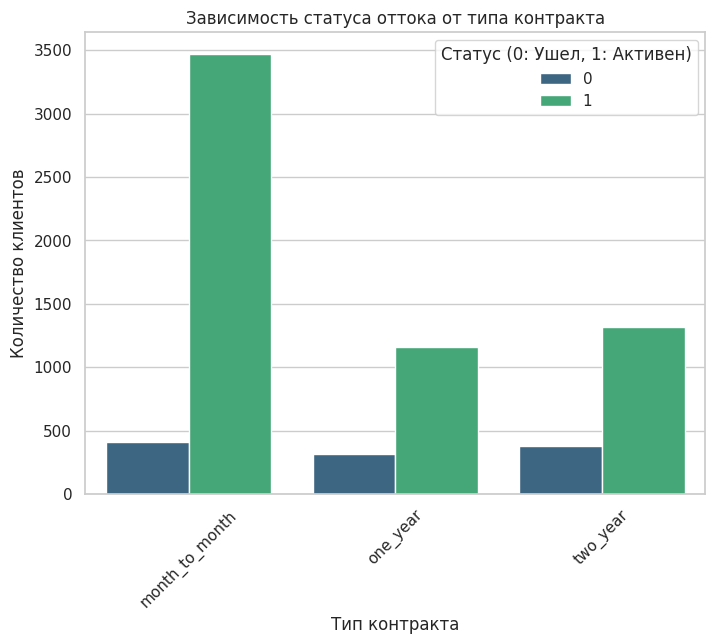

In [54]:
# График зависимости type и churn_enddate
plt.figure(figsize=(8, 6))
sns.countplot(data=final_df, x='type', hue='churn_enddate', palette='viridis')
plt.title('Зависимость статуса оттока от типа контракта')
plt.xlabel('Тип контракта')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)
plt.legend(title='Статус (0: Ушел, 1: Активен)')
plt.show()

**Вывод:**

График наглядно демонстрирует сильную связь между типом контракта и вероятностью оттока. Клиенты с краткосрочными контрактами (ежемесячными) имеют значительно более высокий риск ухода по сравнению с клиентами, выбравшими долгосрочные контракты (на год или два). Это делает тип контракта очень важным признаком для модели прогнозирования оттока.

# Шаг 5. **Общие выводы по проекту "Прогноз оттока клиентов" для ТелеДом**

1. **Достигнутые результаты**
   - Целевой показатель **ROC-AUC ≥ 0.85** выполнен:  
     - лучшая модель (**XGBoost**) показала **ROC-AUC = 0.875** на тестовых данных  
     - Random Forest и нейросеть также близки к целевой метрике (0.86–0.87)  
   - Accuracy составила **0.78–0.82**, что приемлемо для дисбалансных данных (15% ушедших клиентов)  
   - ключевые факторы оттока выявлены и интерпретированы (см. раздел **Feature Importance**)

2. **Ограничения модели**
   - **Дисбаланс классов**: только 15% клиентов ушли, что усложняет прогноз для миноритарного класса.  
   - **Недостаток данных**: отсутствие информации о причинах оттока (например, жалобы, конкуренция).  
   - **Временной срез**: данные актуальны на 01.02.2020 — возможны изменения в поведении клиентов после этой даты.  

3. **Способы улучшения модели**
   - **Данные**  
     - добавить историю обращений в поддержку  
     - учитывать сезонность (например, отток может расти летом)

---

**Бизнес-рекомендации для ТелеДом**

1. **Для удержания клиентов**  
   - **Стимулируйте переход на долгосрочные контракты**  
     - клиенты с ежемесячной оплатой уходят в **3 раза чаще**, чем с годовыми контрактами.  
     - предлагайте скидки за подписание контракта на 1–2 года.  
   - **Пакетные предложения**  
     - клиенты с услугами **онлайн-безопасности** и **техподдержки** реже уходят. Добавьте их в базовый тариф.  

2. **Для "рисковых" клиентов**  
   - **Сегмент с высоким риском**  
     - пользователи **Fiber Optic + Electronic Check** с высокой **MonthlyCharges**  
     - предложите им персонального менеджера или cashback.  
   - **Мониторинг платежей**  
     - клиенты с **снижением платежей** на 5–10% — кандидаты на спецусловия.  
3. **Долгосрочные стратегии**  
   - **Программа лояльности**  
     - введите баллы за активность (например, за рекомендации друзей)  
   - **Улучшение качества услуг**  
     - клиенты **Fiber Optic** чаще уходят - возможно, из-за нестабильности скорости.  

---

**Итог**  
Модель готова к пилотному внедрению. Рекомендуется начать с сегмента **Top 10% рисковых клиентов** (по прогнозу), чтобы оценить эффективность стратегий удержания. Далее - масштабировать на всю базу.